#### 라벨링

In [31]:
import cv2
import os

from collections import defaultdict
from ipywidgets import IntSlider, Label, Button, HBox
from ipycanvas import MultiCanvas, hold_canvas

thickness = 3
y_ratio = 0.5     # percentile of y-position from the top

# Input images
# filename = input("데이터셋으로 사용할 파일명 입력:")
filename = '20240514_015'
img_filename_fmt = 'record/{}/{}_{{}}.jpg'.format(filename, filename)
ann_filename = 'dataset/annotation.txt'.format(filename)
ann_dict = defaultdict(list)

num_frames = len(os.listdir(os.path.dirname(img_filename_fmt)))

cur_index = 1
height, width = cv2.imread(img_filename_fmt.format(cur_index)).shape[:2]
y_value = int(height * y_ratio)

# 추가된 변수: 선 종류를 저장할 변수
line_type = None

def set_image():        
    image = cv2.imread(img_filename_fmt.format(cur_index))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    for pos, dot_line in ann_dict[(filename, cur_index)]:
        color = (0, 255, 0) if dot_line else (255, 0, 0)  # 점선이면 초록색, 아니면 빨간색
        image[pos[1]-thickness//2:pos[1]+thickness//2] = color

    canvas[0].clear()
    canvas[0].put_image_data(image, 0, 0)
    canvas[0].flush()

    cur_fname.value = 'Current image: {:s} | '.format(img_filename_fmt.format(cur_index))

def handle_mouse_move(xpos, ypos):
    with hold_canvas():
        canvas[1].clear()  # 이전에 그려진 포인터를 지웁니다.
        canvas[1].fill_style = "yellow"  # 포인터 색상을 노란색으로 설정
        canvas[1].fill_circle(xpos, ypos, 5)  # 현재 마우스 위치에 새 포인터를 그립니다.


temp_points = []

def handle_mouse_down(xpos, ypos):    
    with hold_canvas():
        if line_type == 'dot':
            canvas[2].fill_style = "green"
        else:
            canvas[2].fill_style = "red"
        canvas[2].fill_circle(xpos, ypos, 5)  # 현재 클릭된 위치에 점을 그립니다.

    cur_pos.value = "({:f}, {:f}) ".format(xpos, ypos)
    temp_points.append([int(float(xpos)), int(float(ypos))])  # 클릭 위치 저장


    
def handle_slider_change(change):
    global y_value
    y_value = change.new
    set_image()
    canvas[1].clear()
    canvas[2].clear()

# def handle_save_button(b):
#     with open(ann_filename, 'a') as f:
#         # print(temp_points)
#         f.write("{:s}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\t{:d}\n".format(img_filename_fmt.format(cur_index),
#                                             temp_points[0][0], temp_points[0][1],
#                                             temp_points[1][0], temp_points[1][1],
#                                             temp_points[2][0], temp_points[2][1],
#                                             temp_points[3][0], temp_points[3][1],
#                                             temp_points[4][0], temp_points[4][1],
#                                             temp_points[5][0], temp_points[5][1]))
#         # for rows in temp_points: 
#         #     # mode_str = 1 if line_type == 'dot' else 0  # 선 종류에 따라 문자열 선택
#         #     f.write("{:s}\t{:d}\t{:d}\n".format(img_filename_fmt.format(cur_index), rows[0], rows[1]))
#         temp_points.clear()  # 파일 저장 후 임시 배열 초기화

def handle_save_button(b):
    with open(ann_filename, 'a') as f:
        # 리스트 내의 좌표들을 문자열로 변환하되, 각 좌표는 공백 없이 ','로 구분하고, 좌표 쌍은 탭으로 구분합니다.
        point_str = ' '.join(f"{x} {y}" for x, y in temp_points)
        full_str = f"{img_filename_fmt.format(cur_index)} {point_str}\n"
        # f.write("{:s}\t{:s}\n".format(img_filename_fmt.format(cur_index), point_str))
        f.write(full_str)
        temp_points.clear()  # 파일 저장 후 임시 배열 초기화


def handle_prev_button(b):
    global cur_index
    cur_index = max(0, cur_index - 1)
    canvas.clear()
    set_image()

def handle_next_button(b):
    global cur_index
    cur_index = min(num_frames + cur_index - 1, cur_index + 1)
    canvas.clear()
    set_image()

def handle_dot_button(b):
    global line_type
    line_type = 'dot'

def handle_notdot_button(b):
    global line_type
    line_type = 'not dot'

# 추가된 버튼과 이벤트 핸들러
dot_line_btn = Button(description='Dot Line Mode', icon='circle')  # 점선 모드 버튼
notdot_line_btn = Button(description='Line Mode', icon='minus')  # 실선 모드 버튼
save_btn = Button(description='Save labels', icon='check')

save_btn.on_click(handle_save_button)

canvas = MultiCanvas(3, width=width, height=height)
cur_fname = Label(value='', disabled=False)
cur_pos = Label(value='', disabled=True)
yslider = IntSlider(description="Y-bar: ", style={'description_width': 'initial'}, value=y_value, min=1, max=height-2, step=1)
prev_btn = Button(description='Prev', icon='arrow-left')
next_btn = Button(description='Next', icon='arrow-right')

set_image()
canvas.on_mouse_move(handle_mouse_move)
canvas.on_mouse_down(handle_mouse_down)
yslider.observe(handle_slider_change, names='value')

dot_line_btn.on_click(handle_dot_button)
notdot_line_btn.on_click(handle_notdot_button)

prev_btn.on_click(handle_prev_button)
next_btn.on_click(handle_next_button)

display(canvas, HBox([cur_fname, cur_pos, yslider]), HBox([prev_btn, next_btn, save_btn, dot_line_btn, notdot_line_btn]))

MultiCanvas(height=540, width=960)

#### 20240514

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import pandas as pd

class LaneDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = []

        with open(txt_file, 'r') as file:
            lines = file.readlines()
            for line in lines:
                parts = line.strip().split()
                img_name = parts[0]
                coordinates = [float(num) for num in parts[1:]]
                self.annotations.append((img_name, coordinates))

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        img_name, coordinates  = self.annotations[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        coordinates = torch.tensor(coordinates)
        return (image, coordinates)

class LaneNet(nn.Module):
    def __init__(self):
        super(LaneNet, self).__init__()
        self.alexnet = models.alexnet(pretrained = True)
        #위치 추정
        self.regressor = nn.Linear(9216,12)

    def forward(self,x):
        features = self.alexnet.features(x)
        features = features.view(features.size(0),-1)
        position = self.regressor(features)
        return position
    
def train(model, train_loader, criterion, optimizer, num_epochs = 10):
    model.train()
    for epoch in range(num_epochs):
        # for images, x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6 in train_loader:
        for images, coordinates in train_loader:
            # positions = [x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6]
            predicted_positions = model(images)
            loss = criterion(predicted_positions, coordinates)
            
            #역전파
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
            
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset = LaneDataset(txt_file = '/home/ircv6/HYU-2024-Embedded/jetracer/dataset/annotation.txt',
                            root_dir = '/home/ircv6/HYU-2024-Embedded/jetracer/record/20240514_015',
                            transform = transform)
train_loader = DataLoader(dataset = train_dataset, batch_size = 4, shuffle = True)

model = LaneNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train(model, train_loader, criterion , optimizer, num_epochs = 20)

/home/ircv6/.local/lib/python3.8/site-packages/torchvision-0.14.1-py3.8-linux-aarch64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ircv6/.local/lib/python3.8/site-packages/torchvision-0.14.1-py3.8-linux-aarch64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


state 저장

In [34]:
torch.save(model.state_dict(),f'model_20240514_004.pth')

이미지에 대한 예측

position: tensor([[277.2290, 337.8035, 269.3621, 286.7203, 271.9456, 226.0791, 266.6232,
         173.3046, 226.8877, 151.4788, 186.5177, 140.3929]])


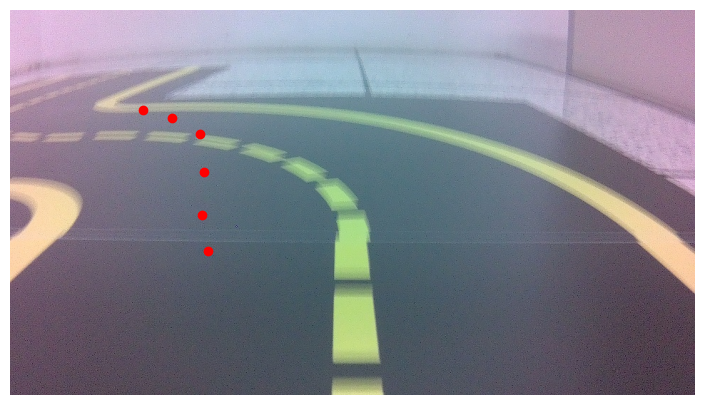

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageDraw
import cv2
model = LaneNet()
model.load_state_dict(torch.load('/home/ircv6/HYU-2024-Embedded/jetracer/model_20240514_004.pth'))
model.eval()

# 이미지 불러오기
image_path = '/home/ircv6/HYU-2024-Embedded/jetracer/record/20240510_003/20240510_003_80.jpg'
image_ori = Image.open(image_path)
# image_ori = cv2.resize(960,540))

# 이미지 전처리
image = transform(image_ori)
image = image.unsqueeze(0)  # 배치 차원 추가 (모델이 배치를 기대하기 때문에)

with torch.no_grad():
    position = model(image)

print('position:', position)
position = position.tolist()
x_position = [0 for _ in range(6)]
y_position = [0 for _ in range(6)]
for i in range(len(position[0])):
    if i % 2 == 0:
        x_position[int(i/2)] = position[0][i]
    else:
        y_position[int(i//2)] = position[0][i]

# probabilities = nn.functional.softmax(classes, dim=1)
# print("Class probabilities:", probabilities)
# print("x_position",x_position)
# print("y_position",y_position)

# 이미지를 보여줄 준비를 합니다.
# image = image.squeeze(0)
# image = image.permute(1,2,0)
plt.figure(figsize=(10, 5))
plt.imshow(image_ori)

# x_position과 y_position에서 좌표를 읽어와서 이미지 위에 점을 찍습니다.
for x, y in zip(x_position, y_position):
    plt.scatter(x, y, color='red')  # 색상과 마커 크기 등을 조정할 수 있습니다.

# 축을 보이지 않게 처리합니다.
plt.axis('off')

# 결과를 보여줍니다.
plt.show()

영상에 대한 예측

In [13]:
from IPython.display import display, Image
import ipywidgets as widgets
import threading
from jetcam.utils import bgr8_to_jpeg
import cv2
from jetcam.csi_camera import CSICamera
from PIL import Image
camera = CSICamera(capture_width=1280, capture_height=720, downsample=2, capture_fps=30)
class LaneDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = []

        with open(txt_file, 'r') as file:
            lines = file.readlines()
            for line in lines:
                parts = line.strip().split()
                img_name = parts[0]
                coordinates = [float(num) for num in parts[1:]]
                self.annotations.append((img_name, coordinates))

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        img_name, coordinates  = self.annotations[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        coordinates = torch.tensor(coordinates)
        return (image, coordinates)

class LaneNet(nn.Module):
    def __init__(self):
        super(LaneNet, self).__init__()
        self.alexnet = models.alexnet(pretrained = True)
        #위치 추정
        self.regressor = nn.Linear(9216,12)

    def forward(self,x):
        features = self.alexnet.features(x)
        features = features.view(features.size(0),-1)
        position = self.regressor(features)
        return position
          
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset = LaneDataset(txt_file = '/home/ircv6/HYU-2024-Embedded/jetracer/dataset/annotation.txt',
                            root_dir = '/home/ircv6/HYU-2024-Embedded/jetracer/record/20240514_015',
                            transform = transform)
train_loader = DataLoader(dataset = train_dataset, batch_size = 4, shuffle = True)

model = LaneNet()
model.load_state_dict(torch.load('/home/ircv6/HYU-2024-Embedded/jetracer/model_20240514_004.pth'))
model.eval()

# Stop button
# ================
stopButton = widgets.Checkbox(
    value=False,
    description='Streaming',
    disabled=False,
    indent=False,
)

# Display function
# ================
def view(button):
    frame = camera.read()
    display_handle=display(Image(data=bgr8_to_jpeg(frame)), display_id=True) 
    
    while not stopButton.value:
        frame = camera.read()
        # Convert to PIL image and process
        pil_frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        input_tensor = transform(pil_frame).unsqueeze(0)

        # Get model prediction
        with torch.no_grad():
            pos = model(input_tensor).squeeze().tolist()

        # Extract positions and draw
        x_position = [int(pos[i]) for i in range(0, len(pos), 2)]
        y_position = [int(pos[i]) for i in range(1, len(pos), 2)]
        for x, y in zip(x_position, y_position):
            cv2.circle(frame, (x, y), 10, (255, 0, 0), -1)
        
        # Update display
        jpeg_frame = bgr8_to_jpeg(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        display_handle.update(Image(data=jpeg_frame))

GST_ARGUS: Creating output stream
CONSUMER: Waiting until producer is connected...
GST_ARGUS: Available Sensor modes :
GST_ARGUS: 3280 x 2464 FR = 21.000000 fps Duration = 47619048 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 3280 x 1848 FR = 28.000001 fps Duration = 35714284 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1920 x 1080 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1640 x 1232 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1280 x 720 FR = 59.999999 fps Duration = 16666667 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: Running with following settings:
   Camera index = 0 
   Camera mode  = 4 
   Output Stream W = 1280 H = 7

[ WARN:0] global /home/ubuntu/build_opencv/opencv/modules/videoio/src/cap_gstreamer.cpp (1100) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1
[ WARN:0] global /home/ubuntu/build_opencv/opencv/modules/videoio/src/cap_gstreamer.cpp (1390) setProperty OpenCV | GStreamer warning: GStreamer: unhandled property


GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success
GST_ARGUS: Creating output stream
CONSUMER: Waiting until producer is connected...
GST_ARGUS: Available Sensor modes :
GST_ARGUS: 3280 x 2464 FR = 21.000000 fps Duration = 47619048 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 3280 x 1848 FR = 28.000001 fps Duration = 35714284 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1920 x 1080 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1640 x 1232 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1280 x 720 FR = 59.999999 fps Duration = 16666667 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: Running with following settings:
   

In [14]:
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

Checkbox(value=False, description='Streaming', indent=False)

Exception in thread Thread-58:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/ircv6/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.8/threading.py", line 870, in run


    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_3252/249732711.py", line 71, in view
TypeError: 'module' object is not callable


In [12]:
camera.release()

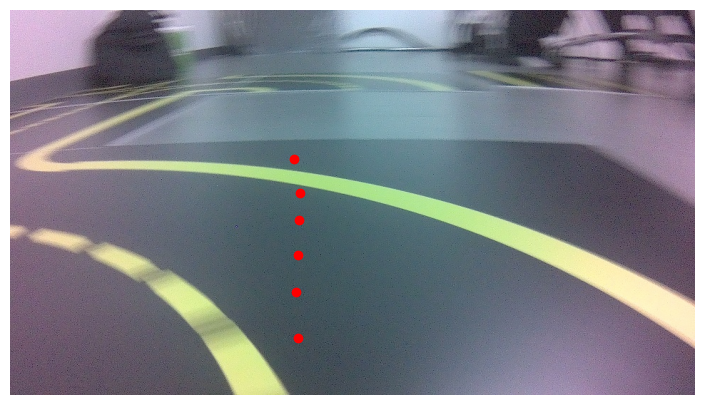

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageDraw

# 먼저 PIL Image 객체가 필요하다고 가정합니다. 예를 들면 이렇게 사용할 수 있습니다.
image = Image.open('/home/ircv6/HYU-2024-Embedded/jetracer/record/20240514_015/20240514_015_80.jpg')

# 이미지를 보여줄 준비를 합니다.
plt.figure(figsize=(10, 5))
plt.imshow(image)

# x_position과 y_position에서 좌표를 읽어와서 이미지 위에 점을 찍습니다.
for x, y in zip(x_position, y_position):
    plt.scatter(x, y, color='red')  # 색상과 마커 크기 등을 조정할 수 있습니다.

# 축을 보이지 않게 처리합니다.
plt.axis('off')

# 결과를 보여줍니다.
plt.show()


In [23]:
import cv2
import copy
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

# 이미지 및 주석 파일 경로 설정
img_filename = '/home/ircv6/HYU-2024-Embedded/jetracer/record/20240510_003/20240510_003_11.jpg'
ann_filename = 'dataset/annotation.txt'

# 주석 파일 읽기
with open(ann_filename, 'r') as f:
    data = [line.strip().split() for line in f.readlines()]
    # 첫 줄의 데이터에서 이미지 파일명과 좌표 추출
filename, coordinates = data[0][0], list(map(int, data[0][1:]))

# 이미지 변환을 위한 Transform 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 이미지 열기
image_ori = Image.open(img_filename)
width, height = image_ori.width, image_ori.height

# 이미지 Transform 적용
image_t = transform(image_ori)
image_t = image_t.unsqueeze(0)  # 모델 입력을 위해 차원 추가

# 모델 로드 및 예측 (이 부분은 모델 정의에 따라 달라질 수 있음)
# model = ...  # 모델 정의 필요
# with torch.no_grad():
#     position = model(image_t)
#     # 예측된 좌표 스케일 변환
#     predicted_coords = (position.view(-1) / 2 + 0.5) * torch.tensor([width, height] * (len(position) // 2))

# 이미지를 Numpy 배열로 변환
image_np = np.array(image_ori)

# GT 좌표 그리기 (각 좌표는 x, y 쌍임)
for i in range(0, len(coordinates), 2):
    cv2.circle(image_np, (coordinates[i], coordinates[i+1]), radius=5, color=(0, 255, 0), thickness=-1)  # GT

# 모델로 예측한 좌표 그리기 (주석 해제 후 사용)
# for i in range(0, len(predicted_coords), 2):
#     x, y = int(predicted_coords[i]), int(predicted_coords[i+1])
#     cv2.circle(image_np, (x, y), radius=5, color=(255, 0, 0), thickness=-1)  # Prediction

# 수정된 이미지를 PIL Image로 변환하여 반환
result_image = Image.fromarray(image_np)
result_image.show()


Unable to init server: Could not connect: Connection refused

(eog:8711): Gtk-WARNING **: 15:37:13.764: cannot open display: 


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import pandas as pd

class LaneDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = []

        with open(txt_file, 'r') as file:
            lines = file.readlines()
            for line in lines:
                parts = line.strip().split()
                img_name = parts[0]
                coordinates = [float(num) for num in parts[1:]]
                self.annotations.append((img_name, coordinates))

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        img_name, coordinates  = self.annotations[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        coordinates = torch.tensor(coordinates)
        return (image, coordinates)


# 데이터셋에서 하나의 샘플을 로드하여 좌표 데이터의 크기를 출력
sample_img, sample_coords = next(iter(DataLoader(train_dataset, batch_size=1)))
print("Coordinates shape:", sample_coords.shape)


Coordinates shape: torch.Size([1, 3])


In [ ]:
# 데이터셋 초기화 및 데이터 로드 테스트
dataset = LaneDataset(txt_file='/path/to/your/label/file.txt', 
                      root_dir='/path/to/your/image/directory', 
                      transform=transforms.ToTensor())  # 필요에 따라 transform 조정

# 첫 번째 데이터셋 아이템 로드
img, coords = dataset[0]
print("Loaded coordinates:", coords)
print("Coordinates shape:", coords.shape)
